$$C(x,y,z,t)={\frac {Q}{(2\pi )^{3/2}\sigma _{x}\sigma _{y}\sigma _{z}}} \exp[-{\frac {((x-x_{0})-ut)^{2}}{2\sigma _{x}^{2}}}] \exp[-{\frac {(y-y_{0})^{2}}{2\sigma _{y}^{2}}}] \{\exp[-{\frac {(z-H)^{2}}{2\sigma _{z}^{2}}}] + \exp[-{\frac {(z+H)^{2}}{2\sigma _{z}^{2}}]\}}]$$

In [90]:
from gaussian_plume_model import GaussianPlumeModel
import numpy as np

# Константы
SOURCE_EMISSION_RATE = 10  # Скорость выброса источника (кг/с)
WIND_SPEED = 3  # Скорость ветра (м/с)
WIND_DIRECTION = 0 # Направление ветра в градусах (Относительно оси X)
RELEASE_HEIGHT = 0  # Высота выброса (м)
# SOURCE_POSITIONS = [(100, 0, 0),   (180, 0, 0),
#                     (100, 40, 0),  (180, 40, 0), (260, 40, 0), 
#                                     (180, 80, 0), (260, 80, 0), 
#                                                     (260, 120, 0)]  # Позиция источника (x0, y0, z0)

SOURCE_POSITIONS = [(500, 0, 0)]
# Параметры сетки
DOMAIN_SIZE_X = 6000  # Размер области по x (м)
DOMAIN_SIZE_Y = 1500  # Размер области по y (м)
NUM_POINTS = 500  # Количество точек для построения

In [ ]:
class NonStationaryGaussianPlumeModel(GaussianPlumeModel):
    # DISPERSION_COEFFICIENTS = {
    # "A": {"a": 1,   "a_1": 0.112,  "a_2": 5.38e-4, "b_1": 1.06,  "b_2": 0.815, 'c_1': 6.45, 'c_2': 2510, "c_3": 0.305,  'c_4': 1.8365, 'd_1': -0.097, 'd_2': -0.44375},
    # "B": {"a": 1.1, "a_1": 0.130,  "a_2": 6.52e-4, "b_1": 0.950, "b_2": 0.750, 'c_1': 6.45, 'c_2': 2510, "c_3": 0.223,  'c_4': 1.8365, 'd_1': -0.097, 'd_2': -0.44375},
    # "C": {"a": 1.2, "a_1": 0.112,  "a_2": 9.05e-4, "b_1": 0.920, "b_2": 0.718, 'c_1': 6.45, 'c_2': 2510, "c_3": 0.1575, 'c_4': 1.8365, 'd_1': -0.097, 'd_2': -0.44375},
    # "D": {"a": 1.3, "a_1": 0.098,  "a_2": 1.35e-3, "b_1": 0.889, "b_2": 0.688, 'c_1': 6.45, 'c_2': 2510, "c_3": 0.1116, 'c_4': 1.8365, 'd_1': -0.097, 'd_2': -0.44375},
    # "E": {"a": 1.3, "a_1": 0.0609, "a_2": 1.96e-3, "b_1": 0.895, "b_2": 0.684, 'c_1': 6.45, 'c_2': 2510, "c_3": 0.816,  'c_4': 1.8365, 'd_1': -0.097, 'd_2': -0.44375},
    # "F": {"a": 1.5, "a_1": 0.0638, "a_2": 1.36e-3, "b_1": 0.783, "b_2": 0.672, 'c_1': 6.45, 'c_2': 2510, "c_3": 0.5583, 'c_4': 1.8365, 'd_1': -0.097, 'd_2': -0.44375}
    # }
    DISPERSION_COEFFICIENTS = {
        "B": {"sigma_y": (0.16, 0.0001), "sigma_z": (0.12, 0.0)},
        "C": {"sigma_y": (0.11, 0.0001), "sigma_z": (0.08, 0.0002)},
        "D": {"sigma_y": (0.08, 0.0001), "sigma_z": (0.06, 0.0015)},
    }
    def __init__(self, domain_size_x, domain_size_y, num_points, source_emission_rate, wind_speed, wind_direction, release_height, source_positions):
        super().__init__(domain_size_x, domain_size_y, num_points, source_emission_rate, wind_speed, wind_direction, release_height, source_positions)

    def calculate_plume_dispersion(self, x: float, stability_class: str) -> tuple[float, float, float]:
        '''
        :x - x-x_0
        '''
        # coeff = self.DISPERSION_COEFFICIENTS.get(stability_class)
        # a,  a1, a2     = coeff["a"],   coeff["a_1"], coeff["a_2"]
        # b1, b2         = coeff["b_1"], coeff["b_2"]
        # c1, c2, c3, c4 = coeff["c_1"], coeff["c_2"], coeff["c_3"], coeff["c_4"]
        # d1, d2         = coeff["d_1"], coeff["d_2"]

        # sigma_y = (c3*x)/np.sqrt(1+c4*10e-4*x)

        # # f = np.log(abs(c1*(x**d1)/(1 + c2*x**d2)))
        # # g = (a1*x**b1)/(1+a2*x**b2)
        # g = a2*x**b2
        # # print(g.max())
        # # sigma_z = (f*g) # v = 0 тк невесомое ЗВ
        # sigma_z = g # v = 0 тк невесомое ЗВ
        coeff = self.DISPERSION_COEFFICIENTS.get(stability_class)
        if not coeff:
            raise ValueError(f"Unknown stability class: {stability_class}")

        a_y, b_y = coeff["sigma_y"]
        a_z, b_z = coeff["sigma_z"]

        sigma_y = a_y * x / np.sqrt(1 + b_y * x)
        sigma_z = a_z * x / np.sqrt(1 + b_z * x)

        sigma_x = 1.3*sigma_y

        return sigma_x, sigma_y, sigma_z

    def calculate_concentration(self, x: np.ndarray, y: np.ndarray, z: float, t: float, stability_class: str) -> np.ndarray:
        """
        Рассчитывает концентрацию загрязнителя с использованием Не Стационарной Гауссовой модели рассеивания примеси.

        :param x: Расстояние по направлению ветра от источника (м).
        :param y: Поперечное расстояние от центральной линии (м).
        :param z: Вертикальное расстояние от земли (м).
        :param t: Время
        :param stability_class: Класс атмосферной стабильности ("B", "C" или "D").
        :return: Массив концентраций.
        """

        if not self.source_positions:
            raise ValueError("source_positions cannot be empty")

        concentration = np.zeros(x.shape)
        for source in self.source_positions:
            x_0 = source[0]
            # print(x_0, end=" - ")
            y_0 = source[1]
            # Маска для точек, которые находятся "после" источника по оси X
            mask = x >= x_0
            
            # Расстояние от источника (только для точек, которые находятся "после" источника)
            distance = np.where(mask, x - x_0, 0)
            
            # Рассчитываем коэффициенты дисперсии только для точек, которые находятся "после" источника            
            sigma_x, sigma_y, sigma_z = self.calculate_plume_dispersion(distance, stability_class)
            
            # Заменяем нулевые значения на очень маленькие положительные числа для избежания деления на 0
            sigma_x = np.where(sigma_x <= 0, 1e-40, sigma_x)
            sigma_y = np.where(sigma_y <= 0, 1e-40, sigma_y)
            sigma_z = np.where(sigma_z <= 0, 1e-40, sigma_z)
            print(f"dx: {sigma_x.min()} - {sigma_x.max()}")
            print(f"dy: {sigma_y.min()} - {sigma_y.max()}")
            print(f"dz: {sigma_z.min()} - {sigma_z.max()}")

            # Вычисляем концентрацию только для точек, которые находятся "после" источника
            term1 = self.source_emission_rate / (((2 * np.pi)**(3/2)) * sigma_x * sigma_y * sigma_z)
            term2 = np.exp(-((x - x_0 - self.wind_speed*t)**2)/(2 * sigma_x ** 2))
            term3 = np.exp(-((y - y_0) ** 2) / (2 * sigma_y ** 2))
            term4 = np.exp(-((z - self.release_height) ** 2) / (2 * sigma_z ** 2))
            term5 = np.exp(-((z + self.release_height) ** 2) / (2 * sigma_z ** 2))
            
            print(f"1: {term1.max()}")
            print(f"2: {term2.max()}")
            print(f"3: {term3.max()}")
            print(f"4: {term4.max()}")
            print(f"5: {term5.max()}")

            c = term1*term2*term3*(term4 + term5)
            # print(c.max())
            # Добавляем концентрацию только для точек, которые находятся "после" источника
            concentration += np.where(mask, c, 0)

        return concentration

In [92]:
# Создание модели
plume_model = NonStationaryGaussianPlumeModel(
    domain_size_x        = DOMAIN_SIZE_X,
    domain_size_y        = DOMAIN_SIZE_Y,
    num_points           = NUM_POINTS,
    source_emission_rate = SOURCE_EMISSION_RATE,
    wind_speed           = WIND_SPEED,
    wind_direction       = WIND_DIRECTION,
    release_height       = RELEASE_HEIGHT,
    source_positions     = SOURCE_POSITIONS
)

# Определение класса стабильности
stability_class = plume_model.determine_atmospheric_stability(WIND_SPEED)

# Создание сетки
x_grid, y_grid = plume_model.create_grid()

# Расчет концентрации
# print(type(concentration))
# print(concentration.max())
concentration = plume_model.calculate_concentration(x_grid, y_grid, 1, 0, stability_class)
print(concentration.max())

dx: 1e-40 - 583.7950553633242
dy: 1e-40 - 449.07311951024934
dz: 1e-40 - 282.84271247461896
-1
1: 6.349363593424098e+119
2: 2.3463537965113085e-11
3: 0.9999944103294429
4: 0.9999937500195312
5: 0.9999937500195312
4.271695639688761e-12


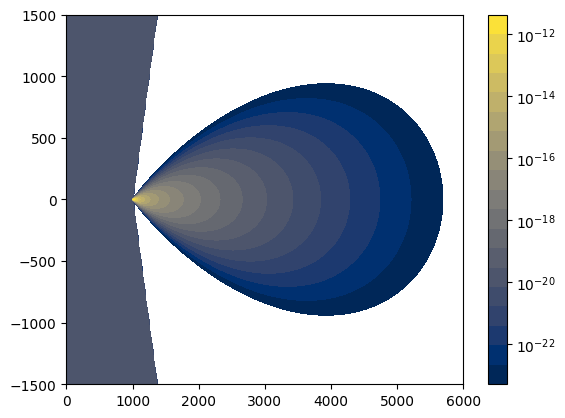

In [93]:
# Отрисовка графика
MIN_CONCENTRATION = 5*10e-25 # Минимальный порог концентрации
plt = plume_model.plot(x_grid, y_grid, concentration, MIN_CONCENTRATION)
plt.show()